#### Single Trial Analysis 
##### New Bonsai NWBs

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
import re
from datetime import datetime
import sys
from pathlib import Path

from aind_dynamic_foraging_data_utils import nwb_utils as nu
import aind_dynamic_foraging_basic_analysis.licks.annotation as a

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu
import array_utils as au
import load_utils as lu

In [2]:
foraging_filepath = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv'

foraging_df = pd.read_csv(foraging_filepath)

# Drop extraneous subject
foraging_df = foraging_df[foraging_df['subject_id'] != 111111]

foraging_df.sort_values(['subject_id', 'session_date', 'trial'], inplace=True)

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_38223/1013867446.py:3: DtypeWarning: Columns (31,38,40,42,52) have mixed types. Specify dtype option on import or set low_memory=False.
  foraging_df = pd.read_csv(foraging_filepath)


In [26]:
foraging_df.columns

Index(['trial', 'animal_response', 'rewarded_historyL', 'rewarded_historyR',
       'bait_left', 'bait_right', 'base_reward_probability_sum',
       'reward_probabilityL', 'reward_probabilityR',
       'reward_random_number_left', 'reward_random_number_right',
       'left_valve_open_time', 'right_valve_open_time', 'block_beta',
       'block_min', 'block_max', 'min_reward_each_block', 'delay_beta',
       'delay_min', 'delay_max', 'delay_duration', 'ITI_beta', 'ITI_min',
       'ITI_max', 'ITI_duration', 'response_duration',
       'reward_consumption_duration', 'auto_waterL', 'auto_waterR',
       'laser_on_trial', 'laser_wavelength', 'laser_location', 'laser_1_power',
       'laser_2_power', 'laser_on_probability', 'laser_duration',
       'laser_condition', 'laser_condition_probability', 'laser_start',
       'laser_start_offset', 'laser_end', 'laser_end_offset', 'laser_protocol',
       'laser_frequency', 'laser_rampingdown', 'laser_pulse_duration',
       'session_wide_control', 

In [25]:
# First identify block transitions as before
block_transitions = ((foraging_df['reward_probabilityL'].shift() != foraging_df['reward_probabilityL']) | 
                    (foraging_df['reward_probabilityR'].shift() != foraging_df['reward_probabilityR'])).astype(int)

# Handle first trials of each session
first_rows_mask = ~foraging_df[['subject_id', 'session_date']].duplicated()
block_transitions.loc[first_rows_mask] = 1

# Create unique block numbers within each session
foraging_df['block'] = block_transitions.groupby([foraging_df['subject_id'], 
                                                foraging_df['session_date']]).cumsum()
foraging_df.head()

,trial,animal_response,rewarded_historyL,rewarded_historyR,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,...,reward_time_in_trial,choice_time_in_session,choice_time_in_trial,earned_reward,extra_reward,subject_id,session_date,reward_delay,minimum_opto_interval,block
1447552,0,2.0,False,False,False,False,0.80,0.088889,0.711111,0.909618,...,NaN,NaN,NaN,False,False,567890,2024-11-01,0.0,0.0,1
1447553,1,2.0,False,False,False,True,0.80,0.088889,0.711111,0.807069,...,NaN,NaN,NaN,False,False,567890,2024-11-01,0.0,0.0,1
868421,0,2.0,False,False,True,False,0.80,0.711111,0.088889,0.426309,...,NaN,NaN,NaN,False,False,641733,2024-01-24,0.0,0.0,1
868422,1,2.0,False,False,True,False,0.80,0.711111,0.088889,0.554599,...,NaN,NaN,NaN,False,False,641733,2024-01-24,0.0,0.0,1
142214,0,1.0,False,False,False,False,0.45,0.400000,0.050000,0.925068,...,NaN,0.43744,0.43744,False,False,684039,2023-10-25,NaN,NaN,1


In [30]:
def chosen_metric_bias(df, global_calc=True):
    """
    Original bias calculation method
    """
    grouped = df.groupby(['subject_id', 'session_date'])
    results = []
    
    for (subject, date), session_df in grouped:
        if global_calc:
            # Original global calculation
            max_prob = max(session_df['reward_probabilityL'].max(), 
                         session_df['reward_probabilityR'].max())
            min_prob = min(session_df['reward_probabilityL'].min(), 
                         session_df['reward_probabilityR'].min())
            
            if max_prob == min_prob:
                continue
                
            choice_bias = []
            for _, trial in session_df.iterrows():
                if trial['animal_response'] == 0:  # Left choice
                    bias = (trial['reward_probabilityL'] - min_prob) / (max_prob - min_prob)
                elif trial['animal_response'] == 1:  # Right choice
                    bias = (trial['reward_probabilityR'] - min_prob) / (max_prob - min_prob)
                else:
                    continue
                choice_bias.append(bias)
            
            results.append({
                'subject_id': subject,
                'session_date': date,
                'chosen_metric': np.mean(choice_bias),
                'calculation': 'global'
            })
            
        else:
            # Local calculation by block
            block_biases = []
            
            for block_num, block_df in session_df.groupby('block'):
                block_max = max(block_df['reward_probabilityL'].max(),
                              block_df['reward_probabilityR'].max())
                block_min = min(block_df['reward_probabilityL'].min(),
                              block_df['reward_probabilityR'].min())
                
                if block_max == block_min:
                    continue
                    
                block_choice_bias = []
                for _, trial in block_df.iterrows():
                    if trial['animal_response'] == 0:  # Left choice
                        bias = (trial['reward_probabilityL'] - block_min) / (block_max - block_min)
                    elif trial['animal_response'] == 1:  # Right choice
                        bias = (trial['reward_probabilityR'] - block_min) / (block_max - block_min)
                    else:
                        continue
                    block_choice_bias.append(bias)
                
                if block_choice_bias:
                    block_biases.append(np.mean(block_choice_bias))
            
            if block_biases:
                results.append({
                    'subject_id': subject,
                    'session_date': date,
                    'chosen_metric': np.mean(block_biases),
                    'calculation': 'local'
                })
    
    return pd.DataFrame(results)

def chosen_metric_difference(df, global_calc=True):
    """
    Current difference calculation method
    """
    grouped = df.groupby(['subject_id', 'session_date'])
    results = []
    
    for (subject, date), session_df in grouped:
        session_df['probability_chosen'] = np.where(
            session_df['animal_response'] == 0,
            session_df['reward_probabilityL'],
            session_df['reward_probabilityR']
        )
        session_df['probability_not_chosen'] = np.where(
            session_df['animal_response'] == 0,
            session_df['reward_probabilityR'],
            session_df['reward_probabilityL']
        )
        
        if global_calc:
            difference = session_df['probability_chosen'] - session_df['probability_not_chosen']
            
            p_larger_global = max(session_df['probability_chosen'].max(), 
                                session_df['probability_not_chosen'].max())
            p_smaller_global = min(session_df['probability_chosen'].min(), 
                                 session_df['probability_not_chosen'].min())
            
            if p_larger_global == p_smaller_global:
                continue
                
            final_metric = difference.mean() / (p_larger_global - p_smaller_global)
            
            results.append({
                'subject_id': subject,
                'session_date': date,
                'chosen_metric': final_metric,
                'calculation': 'global'
            })
            
        else:
            block_metrics = []
            
            for block_num, block_df in session_df.groupby('block'):
                difference = block_df['probability_chosen'] - block_df['probability_not_chosen']
                
                p_larger_block = max(block_df['probability_chosen'].max(),
                                   block_df['probability_not_chosen'].max())
                p_smaller_block = min(block_df['probability_chosen'].min(),
                                    block_df['probability_not_chosen'].min())
                
                if p_larger_block == p_smaller_block:
                    continue
                    
                block_metric = difference.mean() / (p_larger_block - p_smaller_block)
                block_metrics.append(block_metric)
            
            if block_metrics:
                results.append({
                    'subject_id': subject,
                    'session_date': date,
                    'chosen_metric': np.mean(block_metrics),
                    'calculation': 'local'
                })
    
    return pd.DataFrame(results)

In [31]:
# Test both methods
bias_global = chosen_metric_bias(foraging_df, global_calc=True)
bias_local = chosen_metric_bias(foraging_df, global_calc=False)
diff_global = chosen_metric_difference(foraging_df, global_calc=True)
diff_local = chosen_metric_difference(foraging_df, global_calc=False)

# Compare results
results = pd.concat([
    bias_global.assign(method='bias_global'),
    bias_local.assign(method='bias_local'),
    diff_global.assign(method='diff_global'),
    diff_local.assign(method='diff_local')
])

/Users/nickkeesey/miniforge3/envs/Main/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nickkeesey/miniforge3/envs/Main/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [32]:
# Load in session level metrics 

session_metrics = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv')
session_metrics['session_date'] = session_metrics['session_date'].astype('datetime64[ns]')

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_38223/1577903200.py:3: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  session_metrics = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv')


In [73]:
bias_global['session_date'] = bias_global['session_date'].astype('datetime64[ns]')
bias_local['session_date'] = bias_local['session_date'].astype('datetime64[ns]')
diff_global['session_date'] = diff_global['session_date'].astype('datetime64[ns]')
diff_local['session_date'] = diff_local['session_date'].astype('datetime64[ns]')

bias_global_test = bu.merge_dataframes_subject_id(bias_global, session_metrics)
bias_global_test = bu.add_session_column(bias_global_test)

bias_local_test = bu.merge_dataframes_subject_id(bias_local, session_metrics)
bias_local_test = bu.add_session_column(bias_local_test)

diff_global_test = bu.merge_dataframes_subject_id(diff_global, session_metrics)
diff_global_test = bu.add_session_column(diff_global_test)

diff_local_test = bu.merge_dataframes_subject_id(diff_local, session_metrics)
diff_local_test = bu.add_session_column(diff_local_test)


<Axes: xlabel='session', ylabel='chosen_metric'>

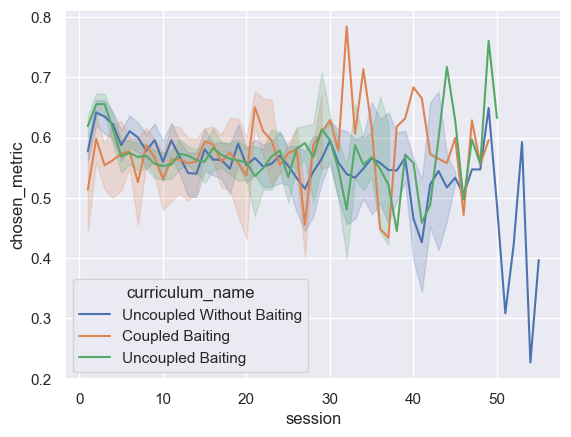

In [74]:
sns.lineplot(bias_global_test, x='session', y='chosen_metric', hue='curriculum_name')

<Axes: xlabel='session', ylabel='chosen_metric'>

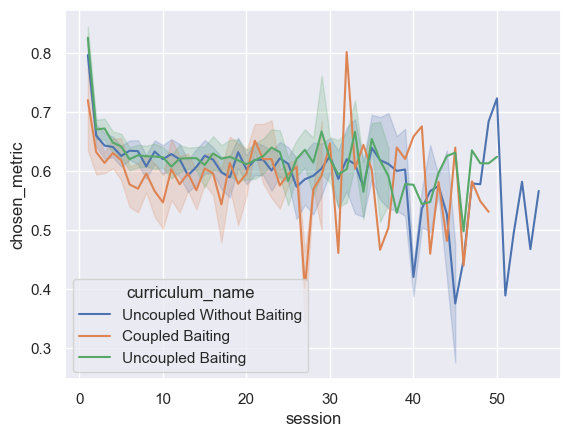

In [75]:
sns.lineplot(bias_local_test, x='session', y='chosen_metric', hue='curriculum_name')

<Axes: xlabel='session', ylabel='chosen_metric'>

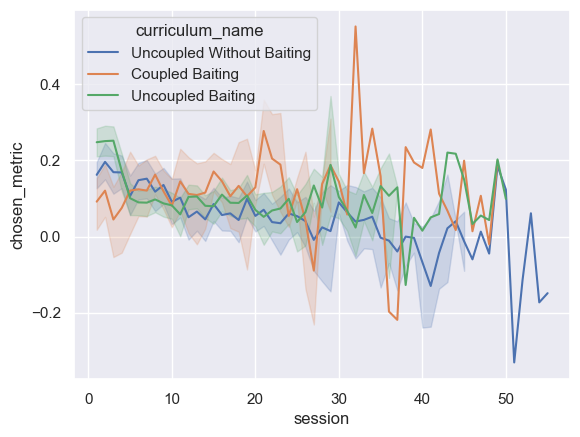

In [76]:
sns.lineplot(diff_global_test, x='session', y='chosen_metric', hue='curriculum_name')

<Axes: xlabel='session', ylabel='chosen_metric'>

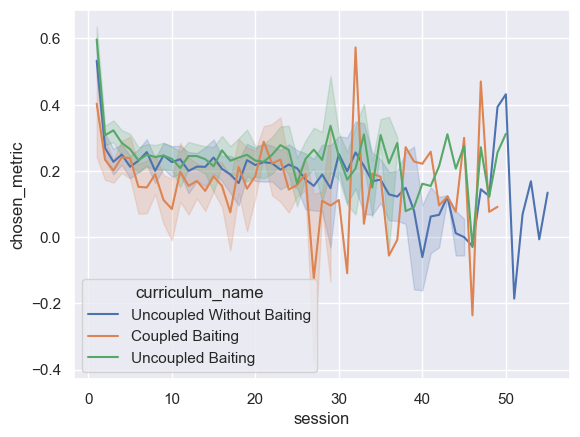

In [92]:
sns.lineplot(diff_local_test, x='session', y='chosen_metric', hue='curriculum_name')